## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Насыбуллин А. А.|
|---------|--------|
| Группа  | М8О-107М-20 VR/AR & ИИ|

Для скачивания датасетов можно Использовать `wget` или `curl`, либо скачать вручную [по ссылке](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz).

### Подлючение модулей и библиотек

In [1]:
import pickle
import numpy as np
import pandas as pd
import os
from time import time
import pandas as pd

%matplotlib inline 
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from matplotlib import gridspec
import seaborn as sns 

from sklearn.model_selection import train_test_split

Настройка Pandas

In [2]:
# установка максимального количества столбцов и строк для вывода
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 25)

# установка количества знаков после запятой
pd.set_option("precision", 2)

## Классы для работы с нейронной сетью

### Класс нейросети

In [3]:
class NeuralNetwork:
  # конструктор
  def __init__(self, layers: [] = []):
    self.layers = layers
  
  # добавление слоя
  def add(self, layer):
    self.layers.append(layer)
  
  # прямой ход: вычисление результа работы нейросети (проход по всем слоям от первого до последнего)
  def forward(self, x):
    for layer in self.layers:
      x = layer.forward(x)
    return x
  
  # обратное распространение ошибки (проход с последнего слоя к первому)
  def backward(self, z):
    for layer in self.layers[::-1]:
      z = layer.backward(z)
    return z
  
  # обновление весов для слоев, имеющих данный функционал
  def update(self, learning_rate: float):
    for layer in self.layers:
      layer.update(learning_rate)

### Класс слоя нейросети

In [4]:
# класс слоя нейросети
class NeuralNetworkLayer:
  def __init__(self, n_inputs:int, n_outputs: int, activation_func):
    self.activation_func = activation_func
    self.weights = np.random.normal(0, 1.0 / np.sqrt(n_inputs), (n_outputs, n_inputs))
    self.bias = np.zeros((1, n_outputs))
    self.d_weights = np.zeros_like(self.weights)
    self.d_bias = np.zeros_like(self.bias)

  # вычисление результата работы слоя
  def forward(self, x):
    self.x = x
    pred = np.dot(x, self.weights.T)
    pred = pred + self.bias
    outputs = self.activation_func.forward(pred)
    return outputs
  
  # обратное распространение ошибки
  def backward(self, dz):
    dz = self.activation_func.backward(dz)
    dx = np.dot(dz, self.weights)
    d_weights = np.dot(dz.T, self.x)
    d_bias = dz.sum(axis=0)
    self.d_weights = d_weights
    self.d_bias = d_bias
    return dx

  # обновление весов
  def update(self, learning_rate: float):
    self.weights -= learning_rate * self.d_weights
    self.bias -= learning_rate * self.d_bias

### Класс функций активации

In [5]:
class ActivationFunction:
  def __init__(self, func: str='softmax'):
    self.func = func
    self.__set_forward__(func)
    self.__set_backward__(func)

  # вычисление результата работы слоя
  def forward(self, z):
    self.forward(self, z)
  
  # обратное распространение ошибки
  def backward(self, dp):
    self.backward(self, dp)
      
  def __set_forward__(self, func):
    if self.func == 'softmax':
      self.forward = self.__softmax_forward__
    elif self.func == 'tanh':
      self.forward = self.__tanh_forward__
    elif self.func == 'sigmoid':
      self.forward = self.__sigmoid_forward__
    else:
      self.forward = self.__softmax_forward__
        
  def __set_backward__(self, func):
    if self.func == 'softmax':
      self.backward = self.__softmax_backward__
    elif self.func == 'tanh':
      self.backward = self.__tanh_backward__
    elif self.func == 'sigmoid':
      self.backward = self.__sigmoid_backward__
    else:
      self.backward = self.__softmax_backward__

  def __sigmoid_forward__(self, x):
    self.sigmoid_x = x
    a = (1/(1+np.exp(-x)))
    self.sigmoid_a = a
    return a

  def __sigmoid_backward__(self, dy):
    return ((self.sigmoid_a) * (1 - self.sigmoid_a)) * dy

  def __softmax_backward__(self, dp):
    p = self.forward(self.softmax_z)
    pdp = p * dp
    result = pdp - p * pdp.sum(axis=1, keepdims=True)
    return result

  def __softmax_forward__(self, z):
    self.softmax_z = z
    zmax = z.max(axis=1, keepdims=True)
    expz = np.exp(z - zmax)
    Z = expz.sum(axis=1, keepdims=True)
    probabilities = expz / Z
    return probabilities

  def __tanh_forward__(self, z):
    y = np.tanh(z)
    self.tanh_y = y
    return y
  
  def __tanh_backward__(self, dy):
    return (1.0 - self.tanh_y**2) * dy

### Класс функций потерь

In [6]:
class LossFunction:
  def __init__(self, func: str='cross-entropy'):
    self.func = func
    self.__set_forward__(func)
    self.__set_backward__(func)

  # вычисление результата работы слоя
  def forward(self, p, y):
    self.forward(self, p, y)
  
  # обратное распространение ошибки
  def backward(self, loss):
    self.backward(self, loss)
      
  def __set_forward__(self, func):
    if self.func == 'cross-entropy':
      self.forward = self.__cross_entropy_forward__
    else:
      self.forward = self.__cross_entropy_forward__
        
  def __set_backward__(self, func):
    if self.func == 'cross-entropy':
      self.backward = self.__cross_entropy_backward__
    else:
      self.backward = self.__cross_entropy_backward__

  def __cross_entropy_forward__(self, p, y):
    self.p = p
    self.y = y
    p_of_y = p[np.arange(len(y)), y]
    self.log_prob = np.log(p_of_y)
    result = -self.log_prob.mean()
    return result
  
  def __cross_entropy_backward__(self, loss):
    dlog_softmax = np.zeros_like(self.p)
    dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0 / len(self.y)
    result = dlog_softmax / self.p
    return result

### Класс для тренировки нейросети

In [7]:
class NeuralNetworkTrainer:
  def __init__(self, mini_batch_size=4, learning_rate=0.01):
    # self.network = network
    self.mini_batch_size = mini_batch_size;
    self.learning_rate = learning_rate;
  
  # обучение нейронной сети эпохами
  def train_epoch(self, net, x_train, y_train, loss):
    for i in range(0, len(x_train), self.mini_batch_size):
      x_batch = x_train[i:i + self.mini_batch_size]
      y_batch = y_train[i:i + self.mini_batch_size]

      pred = net.forward(x_batch)
      losses = loss.forward(pred, y_batch)
  
      d_pred = loss.backward(losses)
      dx = net.backward(d_pred)
      net.update(self.learning_rate)

  # обучение нейронной сети эпохами
  def train_epoch_by_batches(self, net, x_train, y_train, x_test, y_test, n_epoch, loss, n_batches=5):
    metrics = NeuralNetworkMetrics()
    
    train_accurancy = np.empty((n_epoch + 1, 3))
    train_accurancy[:] = np.NAN
    valid_accurancy = np.empty((n_epoch + 1, 3))
    valid_accurancy[:] = np.NAN
    start_time = time()
    
    train_acc = []
    valid_acc = []
    x_batches = np.split(x_train, n_batches)
    y_batches = np.split(y_train, n_batches)
    for epoch in range(n_epoch + 1):
      if epoch != 0:
        for i in range(n_batches):
          self.train_epoch(net, x_batches[i], y_batches[i], loss)
    
      t_loss, t_accuracy = metrics.get_avg_loss_accurancy(net, x_train, y_train, loss, n_batches)
      train_accurancy[epoch, :] = [epoch, t_loss, t_accuracy]

      v_loss, v_accuracy = metrics.get_avg_loss_accurancy(net, x_test, y_test, loss, n_batches)
      valid_accurancy[epoch, :] = [epoch, v_loss, v_accuracy]
      
      if epoch == 0:
        print(f'Initial train loss={t_loss:.3f}, accuracy={t_accuracy:.3f}')
        print(f'Initial valid loss={v_loss:.3f}, accuracy={v_accuracy:.3f}')
    end_time = time()

    train_time = end_time - start_time

    print(f'Final train loss={train_accurancy[-1, 1]:.3f}, accuracy={train_accurancy[-1, 2]:.3f}')
    print(f'Final valid loss={valid_accurancy[-1, 1]:.3f}, accuracy={valid_accurancy[-1, 2]:.3f}')

    return train_accurancy, valid_accurancy, train_time

### Класс для вычислений метрик работы нейросети

In [8]:
class NeuralNetworkMetrics:
  # получение ошибки и точности предсказания
  def get_avg_loss_accurancy(self, net, x, y, loss, n_batches=5):
    sum_losses = np.zeros((n_batches,))
    sum_accurancy = np.zeros((n_batches,))
    x_batches = np.split(x, n_batches)
    y_batches = np.split(y, n_batches)
    for i in range(n_batches):
      losses, accurancy = self.__get_loss_mean_accurancy__(net, x_batches[i], y_batches[i], loss)
      sum_losses[i] = losses
      sum_accurancy[i] = accurancy
    return sum_losses.mean(), sum_accurancy.mean()


  def __get_loss_mean_accurancy__(self, net, x, y, loss):
    pred = net.forward(x)
    losses = loss.forward(pred, y)
    pred_max = np.argmax(pred, axis=1)
    accurancy = (pred_max == y).mean()
    return losses, accurancy


  def get_predicts(self, net, x, y, loss, n_batches=5):
    predicts = []
    x_batches = np.split(x, n_batches)
    y_batches = np.split(y, n_batches)
    for i in range(n_batches):
      predicts.append(self.__get_predicts__(net, x_batches[i], y_batches[i], loss))
    return predicts


  def __get_predicts__(self, net, x, y, loss):
    pred = net.forward(x)
    losses = loss.forward(pred, y)
    pred_max = np.argmax(pred, axis=1)
    # accurancy = (pred_max == y).mean()
    return pred_max

## Вспомогательные функции

### Функция построения матрицы ошибок

In [9]:
def plot_confusion_matrix(net, x_test, y_test, loss, n_batches, 
                          db_name: str, img_dir: str, img_format: str, description: str):
  y_pred = metrics.get_predicts(net, x_test, y_test, loss, n_batches)
  y_pred =  np.array(y_pred).flatten()

  if not os.path.isdir(img_dir):
    os.mkdir(img_dir)

  df_y_test = pd.Series(y_test, name='Actual Class')
  df_y_pred = pd.Series(y_pred, name='Predicted Class')

  df_confusion = pd.crosstab(df_y_test, df_y_pred)
  fig, ax = plt.subplots(figsize=(12, 6))
  sns.heatmap(df_confusion, annot=True, cmap="RdYlGn", linewidths=.5, fmt='.2f', ax=ax);
  title = f'{db_name}. Confussion Matrix (not normalized)'
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  ax.text(x=1.2, y=0.5, s=description, transform=ax.transAxes, fontsize=12,
           verticalalignment='bottom', bbox=props)
  plt.title(title)
  plt.savefig(os.path.join(img_dir, f'{title}{img_format}'), bbox_inches='tight')
  plt.show()

  df_confusion = df_confusion / df_confusion.sum(axis=1)
  fig, ax = plt.subplots(figsize=(10, 6))
  sns.heatmap(df_confusion, annot=True, cmap="RdYlBu", linewidths=.5, fmt='.2f', ax=ax);
  title = f'{db_name}. Confussion Matrix (normalized)'
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  ax.text(x=1.2, y=0.5, s=description, transform=ax.transAxes, fontsize=12,
           verticalalignment='bottom', bbox=props)

  plt.title(title)

  plt.savefig(os.path.join(img_dir, f'{title}{img_format}'), bbox_inches='tight')
  plt.show()

### Функция визуального мониторинга работы нейросети

In [10]:
# обучение и построение графика
def train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch: int, 
                   loss, n_batches, db_name: str, img_dir: str, img_format: str):
  img_name = get_img_name(db_name, len(net.layers), n_epoch, trainer.mini_batch_size, 
                          trainer.learning_rate, loss.func, img_format)

  train_accurancy, valid_accurancy, train_time \
        = trainer.train_epoch_by_batches(net, x_train, y_train, x_test, y_test, 
                                         n_epoch, loss, n_batches)
  x = train_accurancy[:, 0]
  y = (train_accurancy[:, 2], valid_accurancy[:, 2])

  description = f'Database: {db_name}\
  \nLayers: {len(net.layers)}\
  \nActivation Funcs: {[x.activation_func.func for x in net.layers]}\
  \nEpoches: {n_epoch}\
  \nBatches: {n_batches}\
  \nMini Batch Size: {trainer.mini_batch_size}\
  \nLearning Rate: {trainer.learning_rate:.3f}\
  \nLoss Function: {loss.func}\
  \nTrain Time: {train_time:.3f} sec.\
  \nFinal Train Loss: {train_accurancy[-1, 1]:.3f}\
  \nFinal Train Accuracy: {train_accurancy[-1, 2]:.3f}\
  \nFinal Valid Loss: {valid_accurancy[-1, 1]:.3f}\
  \nFinal Valid Accuracy: {valid_accurancy[-1, 2]:.3f}'

  fig, ax = plt.subplots(figsize=(8, 6))
  ax.plot(x, y[0], 'k--', label='training accuracy')
  ax.plot(x, y[1], 'g-', label='validation accuracy')
  ax.legend(loc='lower right')
  ax.set_ylabel('Acurancy')
  ax.set_xlabel('Epoches')
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  ax.text(x=1.2, y=0.5, s=description, transform=ax.transAxes, fontsize=12,
           verticalalignment='bottom', bbox=props)

  title = f'{db_name}. MPL Train and Validation'
  ax.set_title(f'{title}')
  
  if not os.path.isdir(img_dir):
    os.mkdir(img_dir)
  plt.savefig(os.path.join(img_dir, img_name), bbox_inches='tight')
  plt.show()
  return description

### Функция генерции названия картинки

In [11]:
def get_img_name(dataset: str, layers, n_epoch, batch_size, learning_rate, loss_func, format: str):
  return f'DS({dataset})_NL({layers})_E({n_epoch})_B({batch_size})_LR({learning_rate})_LF({loss.func}){format}'

## Установка модулей для загрузки и распаковки данных

In [12]:
!pip install gzip-reader
!pip install rm
!pip install wget

## MNIST

### Настройка путей для сохранения файлов

In [13]:
if 'google.colab' in str(get_ipython()):
    data_dir = os.path.join(os.getcwd(), '/content/data/mnist')
else:
    data_dir = os.path.join(os.getcwd(), '../../../data/mnist')


img_dir = os.path.join(os.getcwd(), 'img_mnist')
if not os.path.isdir(img_dir):
    os.mkdir(img_dir)

### MNIST. Загрузка данных

#### Скачивание данных с помощью инстрмента curl и разархивация данных с помощью инструмента gzip

In [14]:
if 'google.colab' in str(get_ipython()):
  !rm -r /content/data/mnist
  !wget -P data/mnist https://raw.githubusercontent.com/Aynur19/Machine-Learning/main/data/mnist/mnist.pkl.gz
  !gzip -d /content/data/mnist/mnist.pkl.gz
else:
  !gzip -d ../data/mnist/mnist.pkl.gz

--2021-04-28 21:08:45--  https://raw.githubusercontent.com/Aynur19/Machine-Learning/main/data/mnist/mnist.pkl.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10392609 (9.9M) [application/octet-stream]
Saving to: ‘data/mnist/mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]   9.91M  --.-KB/s    in 0.1s    

2021-04-28 21:08:46 (69.9 MB/s) - ‘data/mnist/mnist.pkl.gz’ saved [10392609/10392609]



### MNIST. Чтение и просмотр данных

In [15]:
with open(os.path.join(data_dir, 'mnist.pkl'), 'rb') as f:
    MNIST = pickle.load(f)

MNIST

{'Train': {'Features': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
  'Labels': array([1, 0, 1, ..., 7, 6, 9], dtype=int32)}}

Видно, что имеется 2 набора данных:
- Features - матрица признаковых описаний объектов (значения пикселей каждой картинки)
- Labels - вектор ответов (принадлежность картинки к определенному классу)

Разделим данные на 2 переменные:
- labels - вектор ответов (значения классов)
- data - матрица признаков (значения пикселей)

In [16]:
labels = MNIST['Train']['Labels']
data = MNIST['Train']['Features']

### MNIST. Первоначальный анализ данных, предобработка

Выведем основную информацию:
- количество признаков (пикселей)
- количество объектов (картинок)
- количество разных ответов (классов)

In [17]:
print(f'Количество признаков (пикселей): {data.shape[1]}')
print(f'Количество объектов (картинок): {data.shape[0]}')
print(f'Количество разных ответов (классов): {len(np.unique(labels))}')

Количество признаков (пикселей): 784
Количество объектов (картинок): 42000
Количество разных ответов (классов): 10


Необходимо:
1. Поменять тип данных для признаков на float, чтобы во время обучения и применения нейронных сетей тип данных был везде одинаковый. При приведении к int дробная часть отсекается, что ведет к увеличению погрешности в вычислениях
2. Отмасштабировать все значения пикселей к значениям от 0 до 1,иначе в ходе вычислений большие значения могут привести к ошибкам

In [18]:
data = data.astype(float)
data = data / 255

Разбиваем признаки и ответы на обучающую и тестовую выборки в соотношении 70/30

In [19]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

### MNIST. Применение нейронных сетей и отображение графика обучения

In [20]:
loss = LossFunction('cross-entropy')
metrics = NeuralNetworkMetrics()
n_epoch = 30

Применение нейронной сети с одним слоем (с различными гиперпараметрами)

Initial train loss=2.283, accuracy=0.152
Initial valid loss=2.287, accuracy=0.151
Final train loss=0.286, accuracy=0.921
Final valid loss=0.309, accuracy=0.913


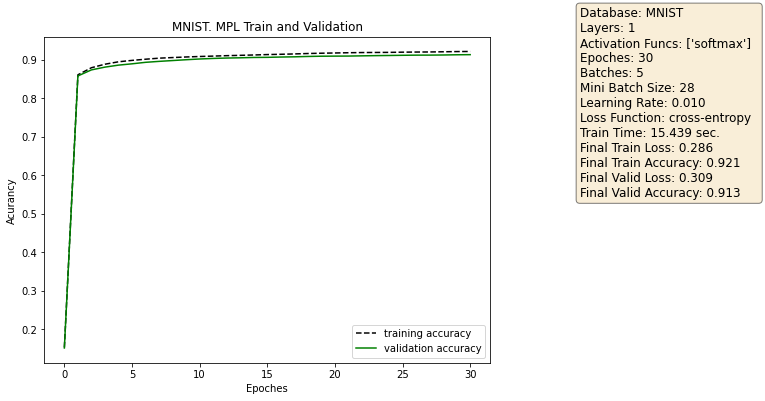

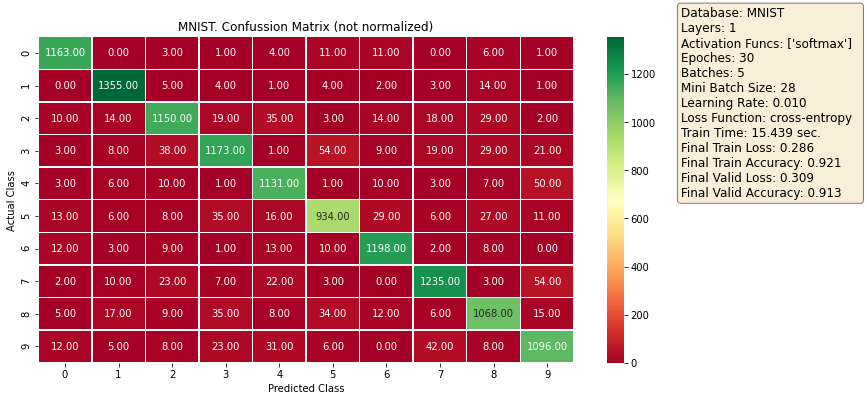

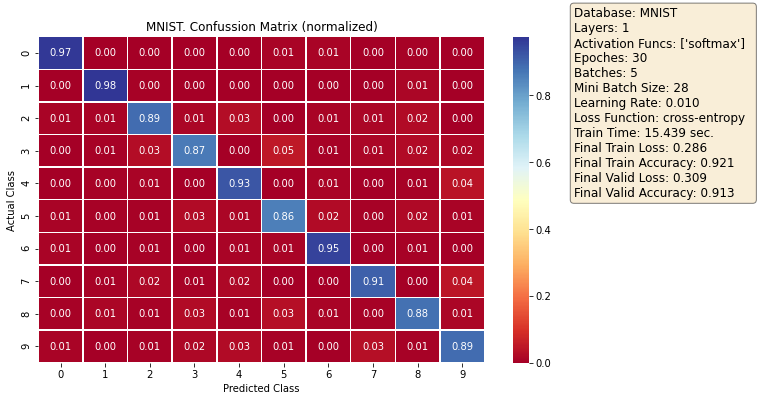

In [21]:
layer1 = NeuralNetworkLayer(784, 10, activation_func=ActivationFunction('softmax'))
net = NeuralNetwork([layer1])
trainer = NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.01)
description = train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='MNIST', img_dir=os.path.join(img_dir, 'l1'), img_format='_1.png')
plot_confusion_matrix(net, x_test, y_test, loss, 5, 'MNIST', os.path.join(img_dir, 'l1'), ' 1.png', description)

Initial train loss=2.338, accuracy=0.113
Initial valid loss=2.342, accuracy=0.111
Final train loss=0.243, accuracy=0.933
Final valid loss=0.286, accuracy=0.919


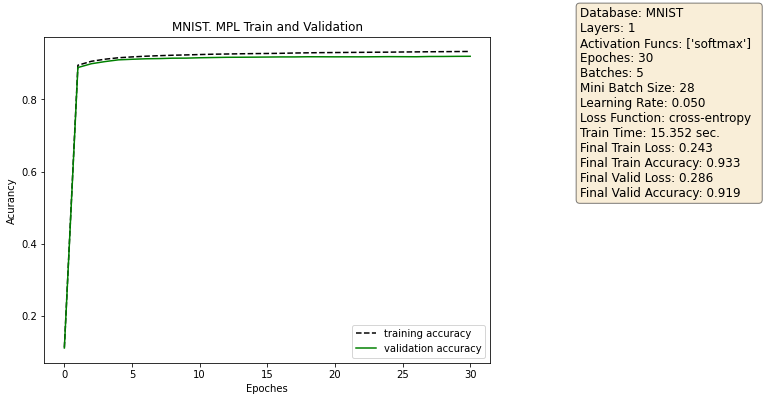

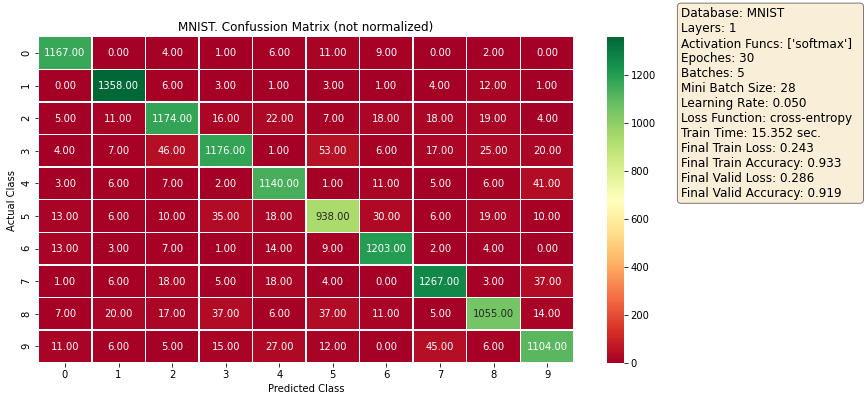

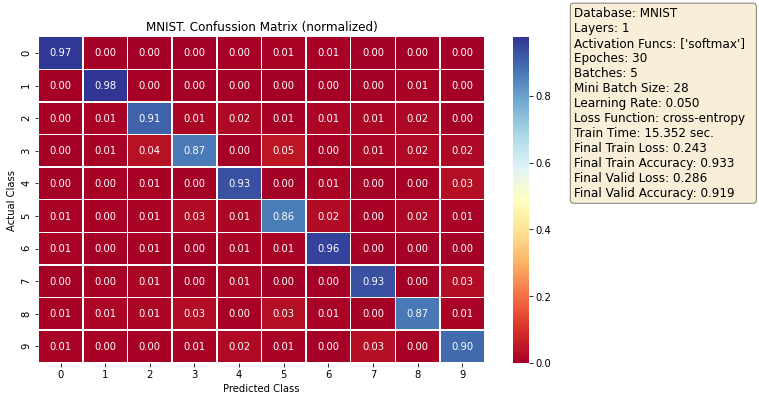

In [22]:
layer1 = NeuralNetworkLayer(784, 10, activation_func=ActivationFunction('softmax'))
net = NeuralNetwork([layer1])
trainer = NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.05)
description = train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='MNIST', img_dir=os.path.join(img_dir, 'l1'), img_format='_2.png')
plot_confusion_matrix(net, x_test, y_test, loss, 5, 'MNIST', os.path.join(img_dir, 'l1'), ' 2.png', description)

Initial train loss=2.400, accuracy=0.117
Initial valid loss=2.401, accuracy=0.115
Final train loss=0.232, accuracy=0.936
Final valid loss=0.290, accuracy=0.919


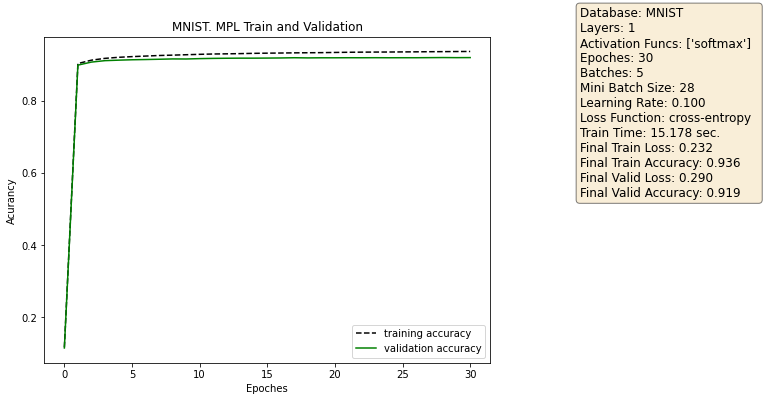

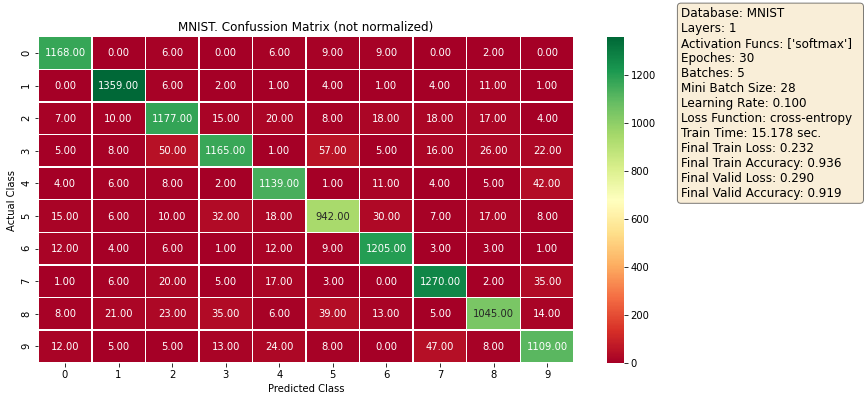

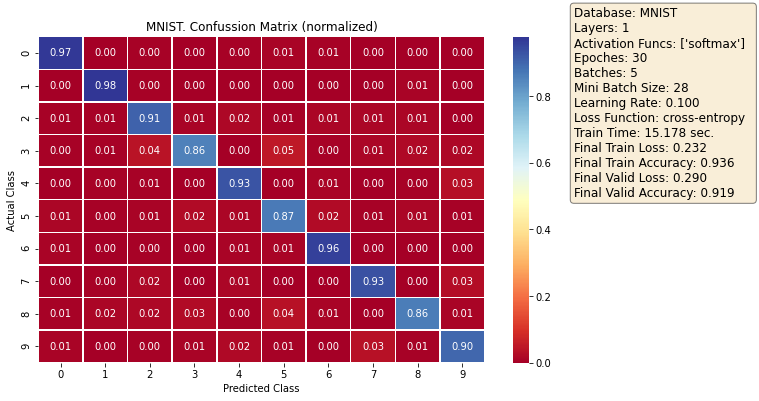

In [23]:
layer1 = NeuralNetworkLayer(784, 10, activation_func=ActivationFunction('softmax'))
net = NeuralNetwork([layer1])
trainer = NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.1)
description = train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='MNIST', img_dir=os.path.join(img_dir, 'l1'), img_format='_3.png')
plot_confusion_matrix(net, x_test, y_test, loss, 5, 'MNIST', os.path.join(img_dir, 'l1'), ' 3.png', description)

### Применение нейронной сети с 2-мя слоями (с различными гиперпараметрами)

Initial train loss=2.384, accuracy=0.061
Initial valid loss=2.380, accuracy=0.059
Final train loss=0.157, accuracy=0.957
Final valid loss=0.192, accuracy=0.944


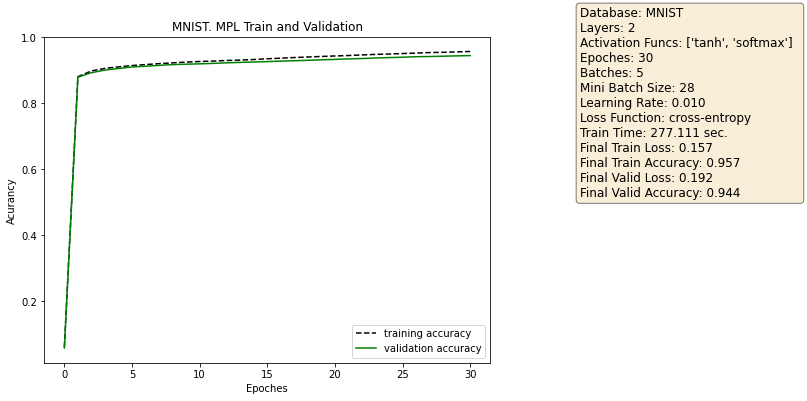

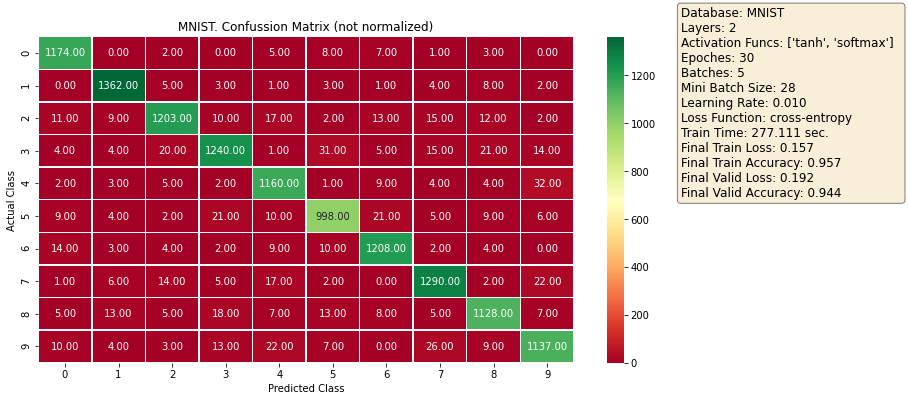

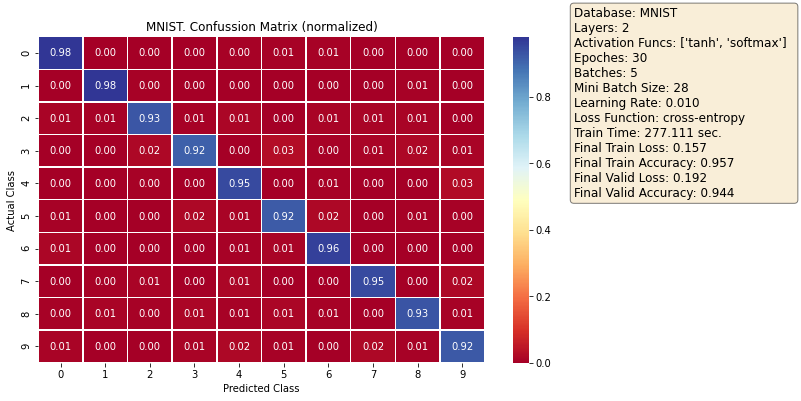

In [24]:
layer1 = NeuralNetworkLayer(784, 392, activation_func=ActivationFunction('tanh'))
layer2 = NeuralNetworkLayer(392, 10, activation_func=ActivationFunction('softmax'))
net = NeuralNetwork([layer1, layer2])
trainer = NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.01)
description = train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='MNIST', img_dir=os.path.join(img_dir, 'l2'), img_format='_1.png')
plot_confusion_matrix(net, x_test, y_test, loss, 5, 'MNIST', os.path.join(img_dir, 'l2'), ' 1.png', description)

Initial train loss=2.339, accuracy=0.105
Initial valid loss=2.333, accuracy=0.109
Final train loss=0.283, accuracy=0.918
Final valid loss=0.303, accuracy=0.912


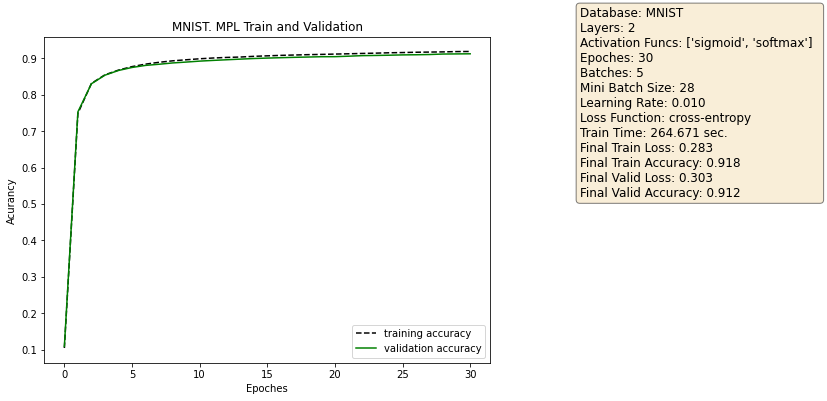

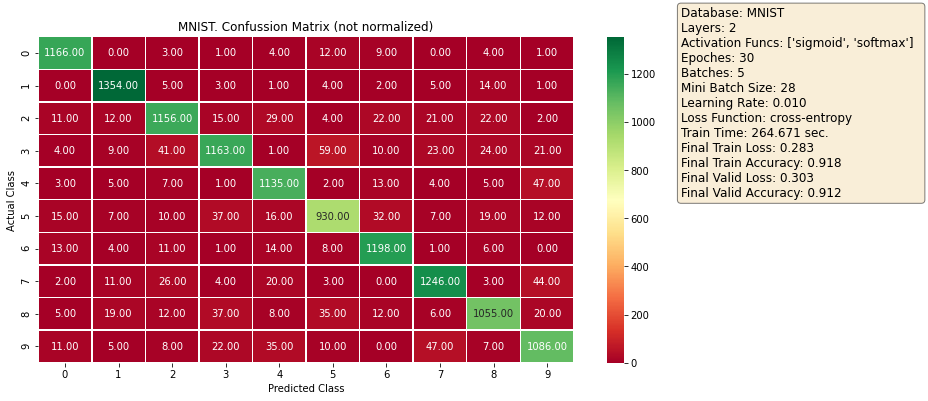

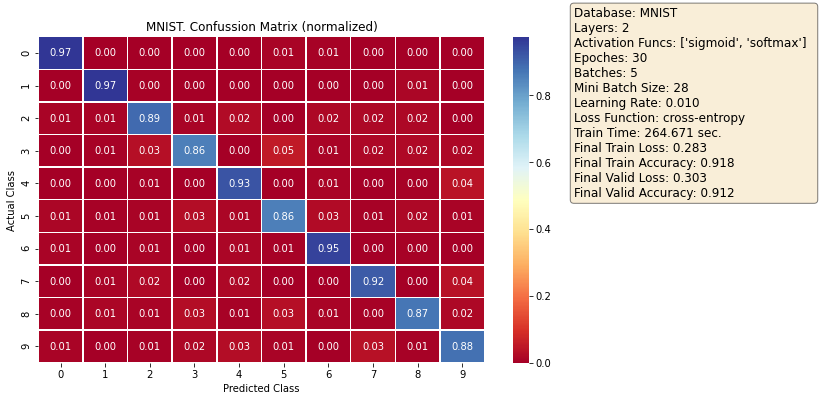

In [25]:
layer1 = NeuralNetworkLayer(784, 392, activation_func=ActivationFunction('sigmoid'))
layer2 = NeuralNetworkLayer(392, 10, activation_func=ActivationFunction('softmax'))
net = NeuralNetwork([layer1, layer2])
trainer = NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.01)
description = train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='MNIST', img_dir=os.path.join(img_dir, 'l2'), img_format='_2.png')
plot_confusion_matrix(net, x_test, y_test, loss, 5, 'MNIST', os.path.join(img_dir, 'l2'), ' 2.png', description)

### Применение нейронной сети с 3-мя слоями (с различными гиперпараметрами)

Initial train loss=2.433, accuracy=0.121
Initial valid loss=2.427, accuracy=0.129
Final train loss=0.191, accuracy=0.945
Final valid loss=0.218, accuracy=0.936


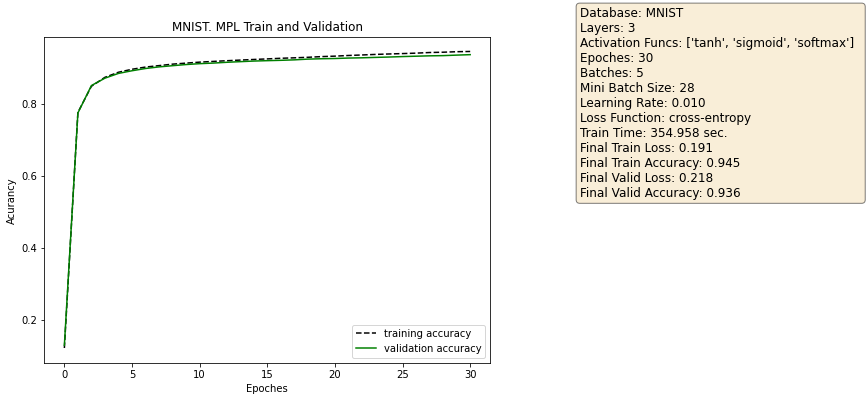

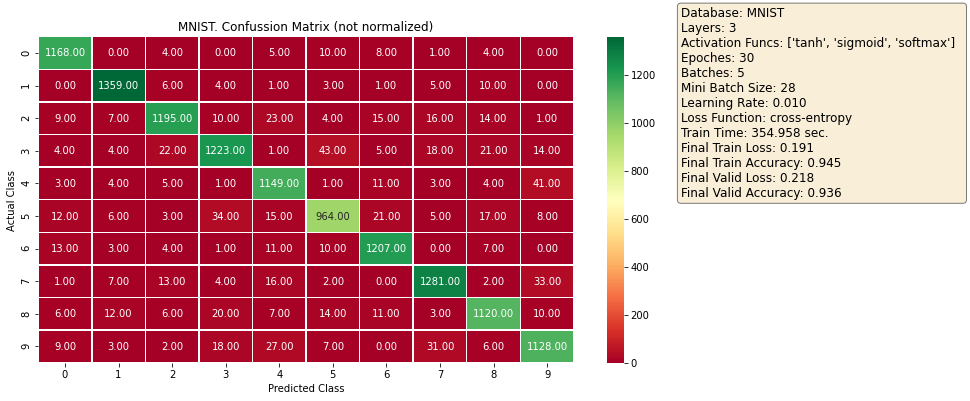

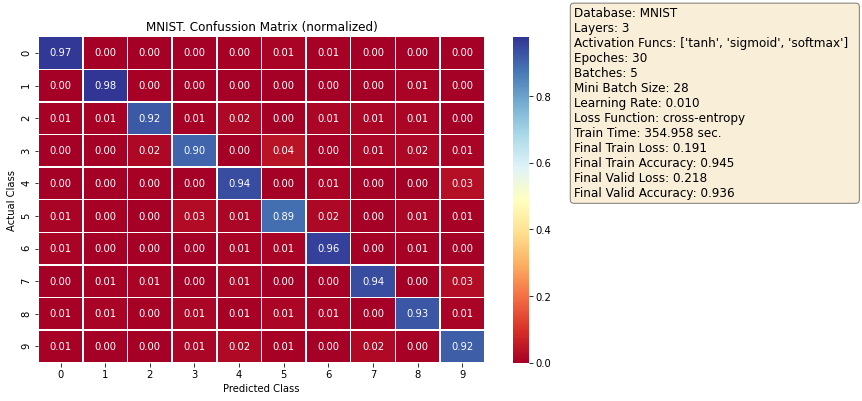

In [26]:
layer1 = NeuralNetworkLayer(784, 392, activation_func=ActivationFunction('tanh'))
layer2 = NeuralNetworkLayer(392, 196, activation_func=ActivationFunction('sigmoid'))
layer3 = NeuralNetworkLayer(196, 10, activation_func=ActivationFunction('softmax'))
net = NeuralNetwork([layer1, layer2, layer3])
trainer = NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.01)
description = train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='MNIST', img_dir=os.path.join(img_dir, 'l3'), img_format='_1.png')
plot_confusion_matrix(net, x_test, y_test, loss, 5, 'MNIST', os.path.join(img_dir, 'l3'), ' 1.png', description)

Initial train loss=2.406, accuracy=0.067
Initial valid loss=2.401, accuracy=0.069
Final train loss=0.565, accuracy=0.854
Final valid loss=0.569, accuracy=0.854


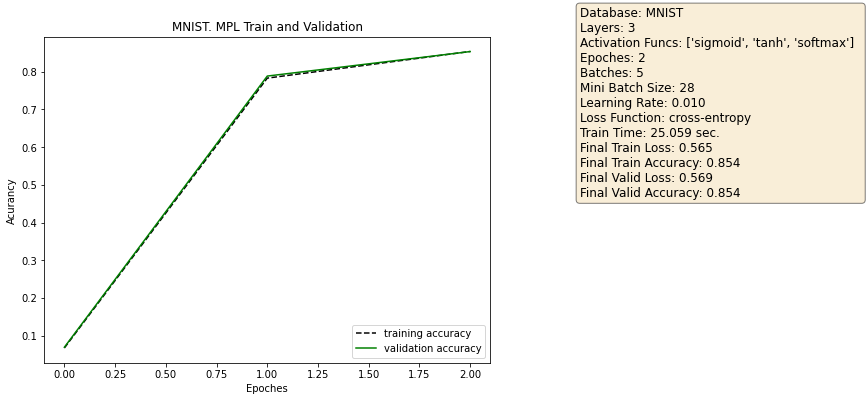

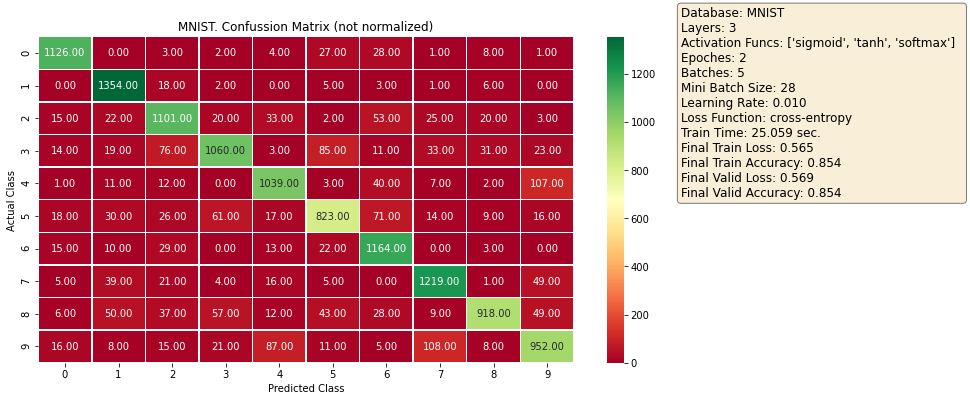

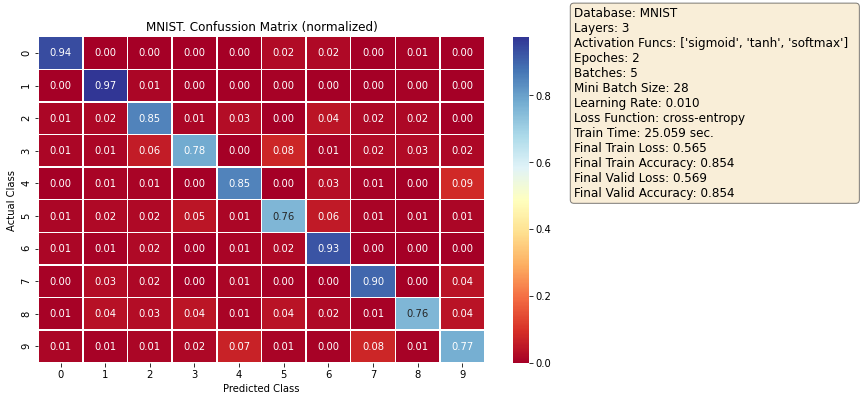

In [27]:
layer1 = NeuralNetworkLayer(784, 392, activation_func=ActivationFunction('sigmoid'))
layer2 = NeuralNetworkLayer(392, 196, activation_func=ActivationFunction('tanh'))
layer3 = NeuralNetworkLayer(196, 10, activation_func=ActivationFunction('softmax'))
net = NeuralNetwork([layer1, layer2, layer3])
trainer = NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.01)
description = train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='MNIST', img_dir=os.path.join(img_dir, 'l3'), img_format='_2.png')
plot_confusion_matrix(net, x_test, y_test, loss, 5, 'MNIST', os.path.join(img_dir, 'l3'), ' 2.png', description)

In [28]:
!zip -r /content/img_mnist.zip /content/img_mnist

  adding: content/img_mnist/ (stored 0%)
  adding: content/img_mnist/l1/ (stored 0%)
  adding: content/img_mnist/l1/DS(MNIST)_NL(1)_E(30)_B(28)_LR(0.01)_LF(cross-entropy)._1.png (deflated 10%)
  adding: content/img_mnist/l1/MNIST. Confussion Matrix (not normalized) 1.png (deflated 4%)
  adding: content/img_mnist/l1/DS(MNIST)_NL(1)_E(30)_B(28)_LR(0.1)_LF(cross-entropy)_3.png (deflated 6%)
  adding: content/img_mnist/l1/MNIST. Confussion Matrix (not normalized) 3.png (deflated 4%)
  adding: content/img_mnist/l1/MNIST. Confussion Matrix (normalized) 1.png (deflated 4%)
  adding: content/img_mnist/l1/DS(MNIST)_NL(1)_E(30)_B(28)_LR(0.01)_LF(cross-entropy)_1.png (deflated 6%)
  adding: content/img_mnist/l1/DS(MNIST)_NL(1)_E(30)_B(28)_LR(0.05)_LF(cross-entropy)_2.png (deflated 6%)
  adding: content/img_mnist/l1/MNIST. Confussion Matrix (not normalized) 2.png (deflated 4%)
  adding: content/img_mnist/l1/MNIST. Confussion Matrix (normalized) 2.png (deflated 4%)
  adding: content/img_mnist/l1/MN

In [29]:
from google.colab import files
files.download("/content/img_mnist.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>